<a href="https://colab.research.google.com/github/milonou/AuctionStart/blob/master/Sarcasm_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [6]:
!pip install clean-text
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, confusion_matrix, auc, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import cv2
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import *
from tensorflow.keras import Model, Input, Sequential
from datetime import datetime
from keras.preprocessing import text, sequence
import keras
import re
import nltk
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
from bs4 import BeautifulSoup
import tweepy
import time
import os
import cleantext
import preprocessor as p
from sklearn import svm


# Authenticate to Twitter

In [8]:
consumer_key = "oy0xhfsdFe4labt0rpMcUExbU"
consumer_secret = "gZAq375MQt1S5mnm1qI3SeAbj13zpOU9Evt7lKkUKBSxvbPhtr"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAKxeWgEAAAAAP5b4EVqm%2BLxmeFqQg8swpurgBdc%3DYrxOYCqVe9ZuedDFdXIqIbo8Av6r19u9nmgKL9MELY9OOyC941"
access_token = "1465268891085590534-vYvD6ShcEMwmo0NQg92CWxpOEkAtAS"
access_token_secret = "qcKBNSeXGeuAbQBGDnEH9eR29V147HwzebHBE3aIrQ15y"

# Authenticate to Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
# test authentication
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


# Συλλογή δεδομένων

In [9]:
to_koulouri = '808452026'
to_vatraxi = '2789977320'
the_press_project = '137041926'
cnn_greece = '3342510514'
huffpost_greece = '2706857144'
count = 10000 

# only 3250 tweets per id can be accessed
try:     
 # Creation of query method using parameters
 tweets_to_koulouri = tweepy.Cursor(api.user_timeline,id=to_koulouri, since="1990-01-01").items()
 tweets_to_vatraxi = tweepy.Cursor(api.user_timeline,id=to_vatraxi, since="1990-01-01").items()
 tweets_huffpost_greece = tweepy.Cursor(api.user_timeline,id=huffpost_greece, since="1990-01-01").items()
 tweets_cnn_greece = tweepy.Cursor(api.user_timeline,id=cnn_greece, since="1990-01-01").items()
#tweets_press_project = tweepy.Cursor(api.user_timeline,id=the_press_project, since="1990-01-01").items()



 # Pulling information from tweets iterable object
 tweets_to_koulouri_list = [tweet.text for tweet in tweets_to_koulouri]
 tweets_to_vatraxi_list = [tweet.text for tweet in tweets_to_vatraxi]
 tweets_huffpost_greece_list = [tweet.text for tweet in tweets_huffpost_greece]
 tweets_cnn_greece_list = [tweet.text for tweet in tweets_cnn_greece]
 #tweets_press_project_list = [tweet.text for tweet in tweets_press_project]

 tweets_sarc_list = tweets_to_koulouri_list + tweets_to_vatraxi_list
 tweets_non_sarc_list = tweets_huffpost_greece_list + tweets_cnn_greece_list

 # Creation of dataframe from tweets list
 # Add or remove columns as you remove tweet information
 tweets_sarc_df_initial = pd.DataFrame(tweets_sarc_list)
 tweets_non_sarc_df_initial = pd.DataFrame(tweets_non_sarc_list)

except BaseException as e:
      print('failed on_status,',str(e))
      time.sleep(3)

print(len(tweets_to_koulouri_list))
print(len(tweets_to_vatraxi_list))
print(len(tweets_huffpost_greece_list))
print(len(tweets_cnn_greece_list))

3250
3250
3250
3250


In [10]:
# assign sarcastic or non sarcastic label
tweets_sarc_df_initial[1] = 1
tweets_non_sarc_df_initial[1] = 0

# Simply for the latex presentation

In [11]:
latex = pd.concat([tweets_sarc_df_initial, tweets_non_sarc_df_initial])
latex = latex.rename(columns={0: "headline", 1: "is_sarcastic"})
latex = latex.sample(frac=1).reset_index(drop=True)
latex.head()

,headline,is_sarcastic
0,Οικονόμου: Ο Ερντογάν διαστρεβλώνει την Ιστορί...,0
1,Σε επιφυλακή δυνάμεις της Πυροσβεστικής σε Πεν...,0
2,"Άδεια μέχρι το τέλος του 2020 πήρε ο Θεός, παρ...",1
3,Και οι 300 βουλευτές συμφωνούν ότι πρέπει να λ...,1
4,Υπό την απειλή λιμού η Σομαλία: Δραματική προε...,0


In [ ]:
latex.head(20)

In [ ]:
print(latex.head(20).to_latex())

In [ ]:
print(latex.head().to_latex())

# Initialize dataframe

In [12]:
tweets_sarc_df = tweets_sarc_df_initial
tweets_non_sarc_df = tweets_non_sarc_df_initial

In [13]:
frames = [tweets_sarc_df, tweets_non_sarc_df]
df = pd.concat(frames)
df = df.sample(frac=1).reset_index(drop=True)
df = df.rename(columns={0: "headline", 1: "is_sarcastic"})
df.head()

,headline,is_sarcastic
0,Το χρώμα του μαγιό των παιδιών μας που μπορεί ...,0
1,https://t.co/aYOFLOw94O,0
2,Έως και 10 φορές πιο γρήγορα έρχονται τα ασανσ...,1
3,"Ηλεκτρικό ρεύμα: Ποιοι θα πάρουν το 1,9 δισ. ε...",0
4,Νόμο που θα απαγορεύει τη φράση «32 Αυγούστου»...,1


In [ ]:
df.head(30)

# Επεξεργασία δεδομένων

In [14]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Replace URLs, Mentions, Numbers, Hashtags and Reserved Words with
# $HASHTAG$ $MENTION$ $URL$ $NUMBER$ $RT$
def clean_tweets(text):
    p.set_options(p.OPT.RESERVED, p.OPT.MENTION, p.OPT.NUMBER, p.OPT.HASHTAG)
    return p.tokenize(text)

def remove_urls(text):
    p.set_options(p.OPT.URL)
    return p.clean(text)

def to_lower_case(text):
  return text.lower()

def replace_new_lines(text):
  return text.replace('\n', ' ')

# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
#    text = clean_special_chars(text, punct)
#    text = remove_stopwords(text)
    text = clean_tweets(text)
#    text = replace_hashtags(text)
#    text = replace_mentions(text)
    text = to_lower_case(text)
    text = remove_urls(text)
    text = replace_new_lines(text)
    return text

In [15]:
# Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/aYOFLOw94O" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/F7ZWEc7ybI" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/wl1W1x1dkQ" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful S

In [16]:
df.head(30)

,headline,is_sarcastic
0,το χρώμα του μαγιό των παιδιών μας που μπορεί ...,0
1,,0
2,έως και $number$ φορές πιο γρήγορα έρχονται τα...,1
3,ηλεκτρικό ρεύμα: ποιοι θα πάρουν το $number$ δ...,0
4,νόμο που θα απαγορεύει τη φράση «32 αυγούστου»...,1
5,νέες εκδόσεις piaggio mp3 με δύο κινητήρες,0
6,έφτασαν ήδη στη γαύδο οι πρώτοι γυμνιστές της ...,1
7,ονόματα ελλήνων πρωθυπουργών θα παίρνουν στο ε...,1
8,ουκρανία: ρωσικοί πύραυλοι στη γενέτειρα του ζ...,0
9,από το $number$: έρευνα: καταφατική απάντηση σ...,1


In [17]:
df['headline'].replace('', np.nan, inplace=True)
df.dropna(subset=['headline'], inplace=True)

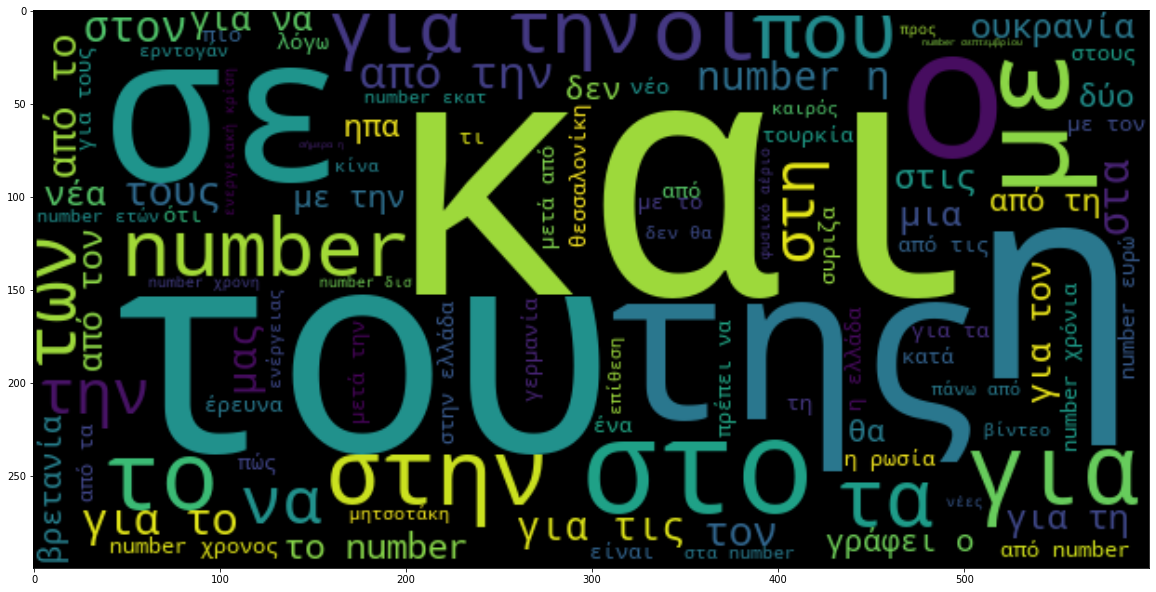

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 100 , width = 600 , height = 300).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

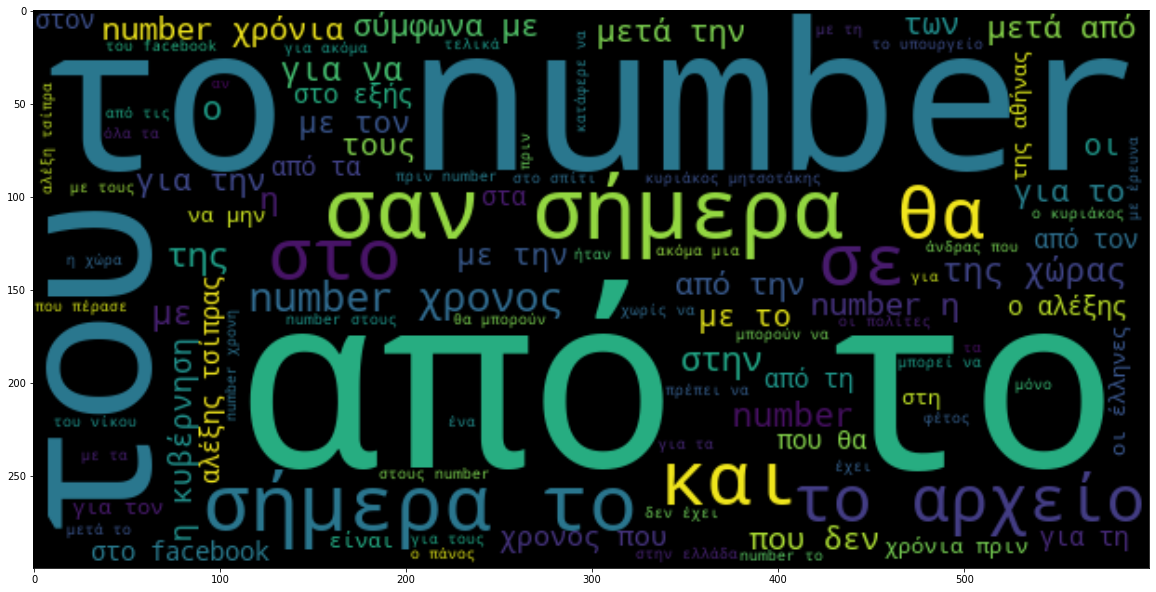

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 100 , width = 600 , height = 300).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
from collections import Counter
results = Counter()
df['headline'].str.lower().str.split().apply(results.update)
print(results)

Counter({'το': 4357, 'του': 3736, 'για': 2992, 'από': 2884, 'η': 2830, 'της': 2753, 'να': 2424, 'ο': 2394, 'την': 2289, 'με': 2145, 'και': 2005, 'που': 1925, 'σε': 1885, '$number$': 1840, 'στο': 1825, 'τα': 1571, 'οι': 1508, 'στην': 1456, 'θα': 1351, 'τον': 1171, 'των': 1130, 'τη': 1044, '$number$:': 987, '-': 897, 'στη': 814, 'δεν': 801, 'τους': 718, 'τις': 684, 'στα': 630, 'μετά': 597, 'είναι': 570, 'στον': 565, 'σαν': 521, 'σήμερα': 510, 'στις': 440, '$number$χρονος': 382, 'ότι': 365, 'αρχείο:': 325, 'νέα': 319, 'κατά': 272, 'στους': 271, 'έχει': 264, 'ένα': 264, 'χρόνια': 256, 'μια': 223, 'χώρας': 220, 'ελλάδα': 214, '$number$η': 209, 'έλληνες': 205, 'δύο': 203, 'αν': 197, 'μας': 197, 'πιο': 191, 'τι': 188, '$number$%': 188, 'κυβέρνηση': 178, 'λόγω': 175, 'πώς': 170, 'σύμφωνα': 166, 'χωρίς': 158, 'νέο': 154, 'έρευνα': 148, 'facebook': 147, 'ευρώ': 147, 'έχουν': 145, 'πριν': 144, 'κάνει': 134, 'γιατί': 130, 'χώρα': 129, 'μέχρι': 128, 'επιστήμονες': 127, 'άνδρας': 127, 'πλέον': 122, 

In [ ]:
print(len(results))

26947


# Load files from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Train test split

In [18]:
x_train, x_test, y_train, y_test = train_test_split( df.headline, df.is_sarcastic , test_size = 0.2) 

# Find length of sentences and number of unique classes

In [19]:
def length(phrase):
  #print(phrase.split())
  return len(phrase.split())

x_train["length"] = x_train.apply(length)
x_test["length"] = x_test.apply(length)
max_len_train = x_train["length"].max()
max_len_test = x_test["length"].max()

max_len = max(max_len_train, max_len_test)
print(max_len)

26


<Figure size 432x288 with 0 Axes>

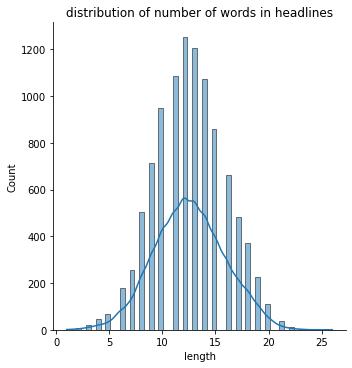

In [20]:
plt.figure()
sns.displot(data = x_train, x = "length", kde = True)
plt.title("distribution of number of words in headlines")
plt.show()

In [21]:
del x_train['length'] # Deleting this column as it is of no use
del x_test['length'] # Deleting this column as it is of no use

In [22]:
unique_classes = df['is_sarcastic'].unique()
print("Unique Classes:", unique_classes )

Unique Classes: [0 1]


In [23]:
max_tokens = 30000

# Tokenization

In [24]:
from tensorflow.keras.layers import TextVectorization

#append x_train and x_test
x_texts = x_train.append(x_test)

vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=26)
text_ds = tf.data.Dataset.from_tensor_slices(x_texts).batch(128)
vectorizer.adapt(text_ds)

In [25]:
print(x_texts)

1664     βρετανίδα εργάζεται ως σοβατζής αλλά είναι «πο...
1315     από το αρχείο: να μπει διαχειρίστρια στις ελλη...
4714     κατευθείαν στη φυλακή θα οδηγούνται στο εξής ό...
6234     ενθουσιασμένος ο δημήτρης λιγνάδης από τον ψυχ...
10532    το μυστικό για μια πετυχημένη δίαιτα είναι να ...
                               ...                        
5046     νόμο που θα απαγορεύει στα ζευγάρια να αποκοιμ...
7514     εκατό χρόνια μετά την γενοκτονία του από τους ...
2536     νεκροί χιλιάδες βρυκόλακες που ξέχασαν την αλλ...
7958     πρώην αναρχικός που έγινε μπάρμαν δεν μπορεί ν...
2686     φωτιά στο σέιχ σου στη θεσσαλονίκη: μεγάλη κιν...
Name: headline, Length: 12681, dtype: object


In [26]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
print(len(voc))

24457


# POS tagging

In [27]:
import nltk
nltk.download('wordnet')
nltk.download('omw')
nltk.download('punkt')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Pad sentences

In [28]:
t = Tokenizer()

# append x_train and x_test
x_texts = x_train.append(x_test)

t.fit_on_texts(x_texts)
encoded_train = t.texts_to_sequences(x_train)
encoded_test = t.texts_to_sequences(x_test)

padded_train = pad_sequences(encoded_train, 
                             maxlen = max_len, 
                             padding = "post", 
                             truncating = "post")

padded_test = pad_sequences(encoded_test, 
                            maxlen = max_len, 
                            padding = "post", 
                            truncating = "post")

print(padded_train.shape, padded_test.shape, type(padded_train))

(10144, 26) (2537, 26) <class 'numpy.ndarray'>


In [29]:
print(len(t.word_index))

24317





# Variables for model initialization

In [30]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)
batch_size = 32
epochs = 10


# Simple LSTM

In [31]:
vocab_size = len(voc) + 2
embedding_dim = 200

In [32]:
tf.keras.backend.clear_session()
input = Input(shape = (max_len, ), name = "input")
embedding = Embedding(input_dim = vocab_size,  output_dim = embedding_dim)(input)

dropout = SpatialDropout1D(.25)(embedding)

lstm = LSTM(180, return_sequences=True, dropout=.5)(dropout)
normalization = BatchNormalization()(lstm)

lstm2 = LSTM(90, return_sequences=True)(normalization)
normalization2 = BatchNormalization()(lstm2)

lstm3 = LSTM(40, dropout=.5)(normalization2)
normalization3 = BatchNormalization()(lstm3)

dense = Dense(20, activation = "relu")(normalization3)

output = Dense(1, activation = "sigmoid")(dense)

model = Model(inputs = input, outputs = output)

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 26)]              0         
                                                                 
 embedding (Embedding)       (None, 26, 200)           4891800   
                                                                 
 spatial_dropout1d (SpatialD  (None, 26, 200)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 26, 180)           274320    
                                                                 
 batch_normalization (BatchN  (None, 26, 180)          720       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 26, 90)            97560 

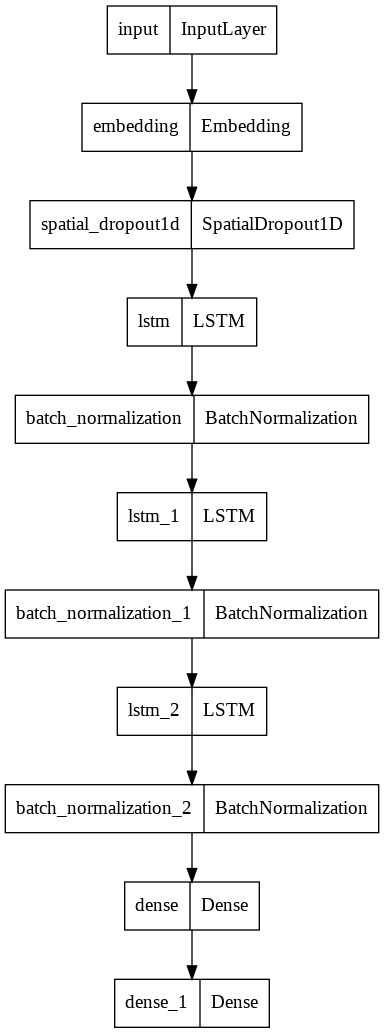

In [33]:
plot_model(model, to_file='model_simple_lstm_plot.png', show_layer_names=True)

In [34]:
# early stopping callback
es = EarlyStopping(monitor = "val_accuracy", 
                          patience = 7, 
                          verbose = 1,  
                          restore_best_weights = True, 
                          mode = 'max')
callbacks=[es]
history = model.fit(padded_train, y_train, epochs = 100, validation_split=.2, verbose=1, callbacks=[es])

Epoch 1/100
254/254 [==============================] - 55s 183ms/step - loss: 0.5316 - accuracy: 0.7274 - val_loss: 0.3237 - val_accuracy: 0.8635
Epoch 2/100
254/254 [==============================] - 47s 187ms/step - loss: 0.2487 - accuracy: 0.9051 - val_loss: 0.2424 - val_accuracy: 0.9000
Epoch 3/100
254/254 [==============================] - 44s 174ms/step - loss: 0.1166 - accuracy: 0.9598 - val_loss: 0.2137 - val_accuracy: 0.9305
Epoch 4/100
254/254 [==============================] - 45s 177ms/step - loss: 0.0589 - accuracy: 0.9804 - val_loss: 0.2692 - val_accuracy: 0.9192
Epoch 5/100
254/254 [==============================] - 44s 173ms/step - loss: 0.0367 - accuracy: 0.9864 - val_loss: 0.3077 - val_accuracy: 0.9256
Epoch 6/100
254/254 [==============================] - 45s 177ms/step - loss: 0.0353 - accuracy: 0.9884 - val_loss: 0.2605 - val_accuracy: 0.9231
Epoch 7/100
254/254 [==============================] - 44s 173ms/step - loss: 0.0211 - accuracy: 0.9945 - val_loss: 0.2246 -

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(padded_test,y_test)[1]*100)

79/79 [==============================] - 3s 38ms/step - loss: 0.3855 - accuracy: 0.9188
Accuracy of the model on Testing Data is -  91.8757438659668


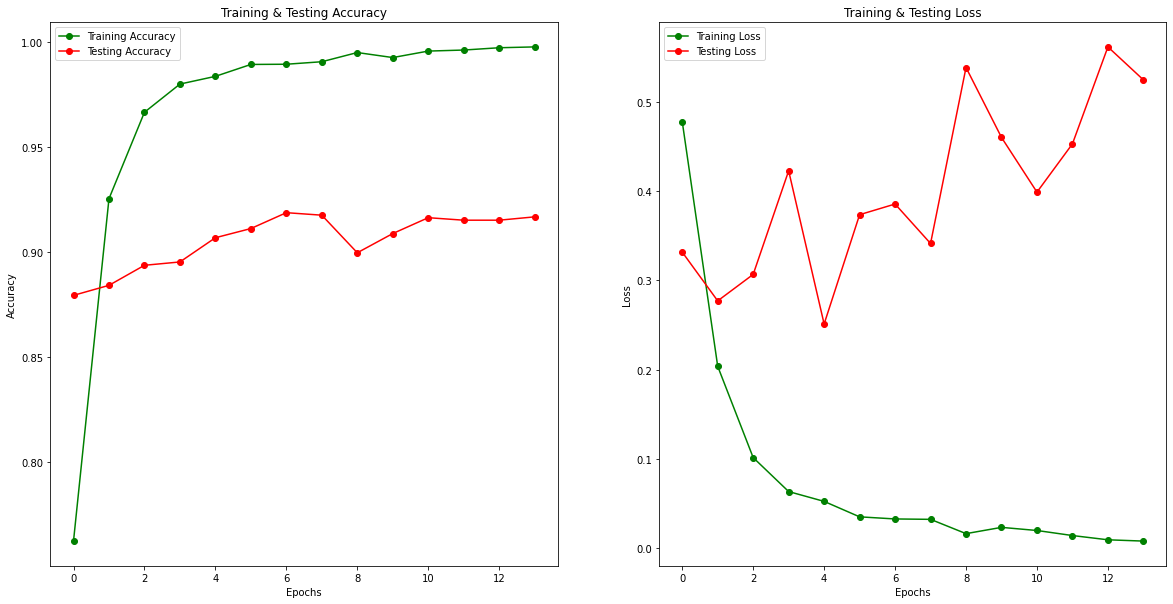

In [ ]:
epochs = [i for i in range(14)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
y_pred_softmax = model.predict(padded_test)
y_pred = []
for i in range(len(y_pred_softmax)):
  if  y_pred_softmax[i][0] >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

Accuracy: 91.8757467144564


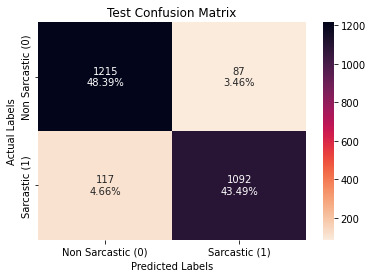

In [ ]:
print("Accuracy:", 100*accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot = labels, fmt='', cmap = sns.cm.rocket_r)
ax.xaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])
ax.yaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.set_title("Test Confusion Matrix")

plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.91      0.93      0.92      1302
    Sarcastic       0.93      0.90      0.91      1209

     accuracy                           0.92      2511
    macro avg       0.92      0.92      0.92      2511
 weighted avg       0.92      0.92      0.92      2511



# BiLSTM

In [ ]:
tf.keras.backend.clear_session()
input = Input(shape = (max_len, ), name = "input")
embedding = Embedding(input_dim = vocab_size,  output_dim = embedding_dim)(input)


dropout = SpatialDropout1D(.25)(embedding)

bilstm = Bidirectional(LSTM(64, dropout=.5))(dropout)
dropout2 = Dropout(0.5)(bilstm)

output = Dense(1, activation = "sigmoid")(dropout2)

model = Model(inputs = input, outputs = output)

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 26)]              0         
                                                                 
 embedding (Embedding)       (None, 26, 200)           4924200   
                                                                 
 spatial_dropout1d (SpatialD  (None, 26, 200)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129   

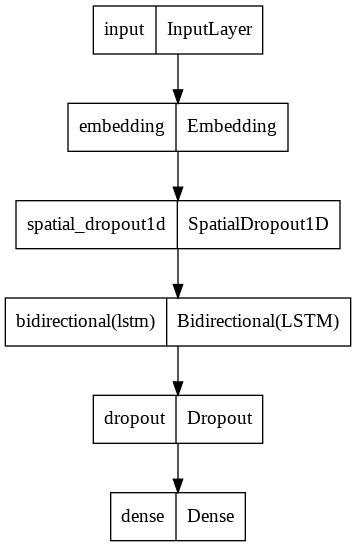

In [ ]:
plot_model(model, to_file='model_bilstm_plot.png', show_layer_names=True)

In [ ]:
# early stopping callback
es = EarlyStopping(monitor = "val_accuracy", 
                          patience = 7, 
                          verbose = 1,  
                          restore_best_weights = True, 
                          mode = 'max')
callbacks=[es]
history = model.fit(padded_train, y_train, epochs = 100, validation_data=(padded_test, y_test), verbose=1, callbacks=[es])

Epoch 1/100
314/314 [==============================] - 40s 107ms/step - loss: 0.3928 - accuracy: 0.8124 - val_loss: 0.1958 - val_accuracy: 0.9215
Epoch 2/100
314/314 [==============================] - 41s 131ms/step - loss: 0.0839 - accuracy: 0.9692 - val_loss: 0.1766 - val_accuracy: 0.9299
Epoch 3/100
314/314 [==============================] - 29s 94ms/step - loss: 0.0146 - accuracy: 0.9957 - val_loss: 0.2257 - val_accuracy: 0.9291
Epoch 4/100
314/314 [==============================] - 29s 93ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.3144 - val_accuracy: 0.9255
Epoch 5/100
314/314 [==============================] - 30s 94ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 0.2455 - val_accuracy: 0.9271
Epoch 6/100
314/314 [==============================] - 30s 96ms/step - loss: 8.1972e-04 - accuracy: 0.9998 - val_loss: 0.3327 - val_accuracy: 0.9279
Epoch 7/100
314/314 [==============================] - 29s 94ms/step - loss: 7.3037e-04 - accuracy: 0.9997 - val_loss: 0.340

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(padded_test,y_test)[1]*100)

79/79 [==============================] - 1s 9ms/step - loss: 0.1766 - accuracy: 0.9299
Accuracy of the model on Testing Data is -  92.99083948135376


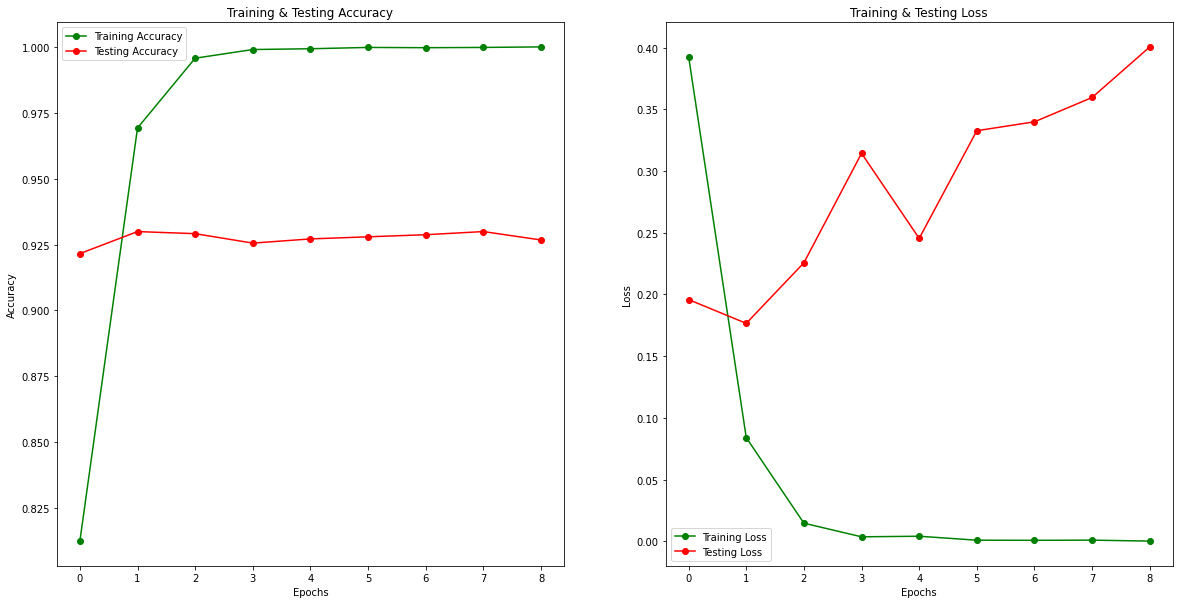

In [ ]:
epochs = [i for i in range(9)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
y_pred_softmax = model.predict(padded_test)
y_pred = []
for i in range(len(y_pred_softmax)):
  if  y_pred_softmax[i][0] >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

Accuracy: 92.99084030266826


Text(0.5, 1.0, 'Test Confusion Matrix')

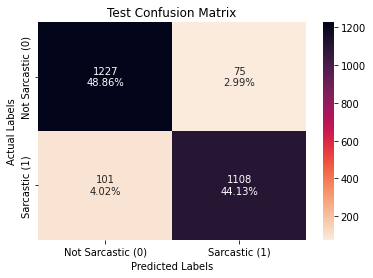

In [ ]:
print("Accuracy:", 100*accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot = labels, fmt='', cmap = sns.cm.rocket_r)
ax.xaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])
ax.yaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.set_title("Test Confusion Matrix")

In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Not Sarcastic','Sarcastic']))

# Word2Vec - LSTM

In [ ]:
import os
path_to_word2vec_file = os.path.join(
    os.path.expanduser("~"), "/content/drive/MyDrive/46 (Word2Vec Continuous Skipgram)/model2.txt"
)

In [ ]:
embeddings_index_for_word2vec = {}
with open(path_to_word2vec_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index_for_word2vec[word] = coefs
        #print(word)

print("Found %s word vectors." % len(embeddings_index_for_word2vec))

Found 1183175 word vectors.


In [ ]:
vocab_size = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index_for_word2vec.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
        #print('hit: ', word)
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 20768 words (3804 misses)


In [ ]:
embedding_matrix.shape

(24574, 100)

In [ ]:
tf.keras.backend.clear_session()
input = Input(shape = (max_len, ), name = "input")
embedding = Embedding(input_dim = vocab_size, 
                      output_dim = embedding_dim, # word2vec vector size
                      weights = [embedding_matrix], 
                      trainable = True)(input)

dropout = SpatialDropout1D(.25)(embedding)

lstm = LSTM(180, return_sequences=True)(dropout)
normalization = Dropout(.5)(lstm)

lstm2 = LSTM(90)(normalization)
normalization2 = Dropout(.2)(lstm2)

lstm3 = LSTM(40)(normalization)
normalization3 = Dropout(.5)(lstm3)

dense = Dense(20, activation = "relu")(normalization3)

output = Dense(1, activation = "sigmoid")(dense)

model = Model(inputs = input, outputs = output)

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 26)]              0         
                                                                 
 embedding (Embedding)       (None, 26, 100)           2457400   
                                                                 
 spatial_dropout1d (SpatialD  (None, 26, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 26, 180)           202320    
                                                                 
 dropout (Dropout)           (None, 26, 180)           0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                35360     
                                                             

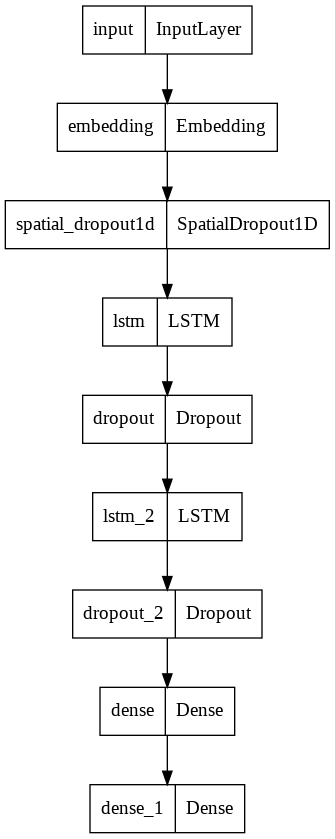

In [ ]:
plot_model(model, to_file='model_word2vec_plot.png', show_layer_names=True)

In [ ]:
# early stopping callback
es = EarlyStopping(monitor = "val_accuracy", 
                          patience = 7, 
                          verbose = 1,  
                          restore_best_weights = True, 
                          mode = 'max')
callbacks=[es]
history = model.fit(padded_train, y_train, batch_size = 32 , validation_data = (padded_test,y_test) , epochs = 100, callbacks=[es])

Epoch 1/100
320/320 [==============================] - 44s 120ms/step - loss: 0.5336 - accuracy: 0.7211 - val_loss: 0.3355 - val_accuracy: 0.8517
Epoch 2/100
320/320 [==============================] - 37s 117ms/step - loss: 0.2657 - accuracy: 0.8927 - val_loss: 0.2915 - val_accuracy: 0.8721
Epoch 3/100
320/320 [==============================] - 37s 115ms/step - loss: 0.1338 - accuracy: 0.9529 - val_loss: 0.2031 - val_accuracy: 0.9268
Epoch 4/100
320/320 [==============================] - 37s 115ms/step - loss: 0.0706 - accuracy: 0.9753 - val_loss: 0.2276 - val_accuracy: 0.9261
Epoch 5/100
320/320 [==============================] - 37s 116ms/step - loss: 0.0373 - accuracy: 0.9880 - val_loss: 0.3562 - val_accuracy: 0.9284
Epoch 6/100
320/320 [==============================] - 37s 117ms/step - loss: 0.0321 - accuracy: 0.9896 - val_loss: 0.2640 - val_accuracy: 0.9214
Epoch 7/100
320/320 [==============================] - 37s 117ms/step - loss: 0.0218 - accuracy: 0.9932 - val_loss: 0.3580 -

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(padded_test,y_test)[1]*100)

80/80 [==============================] - 2s 26ms/step - loss: 0.3562 - accuracy: 0.9284
Accuracy of the model on Testing Data is -  92.84037351608276


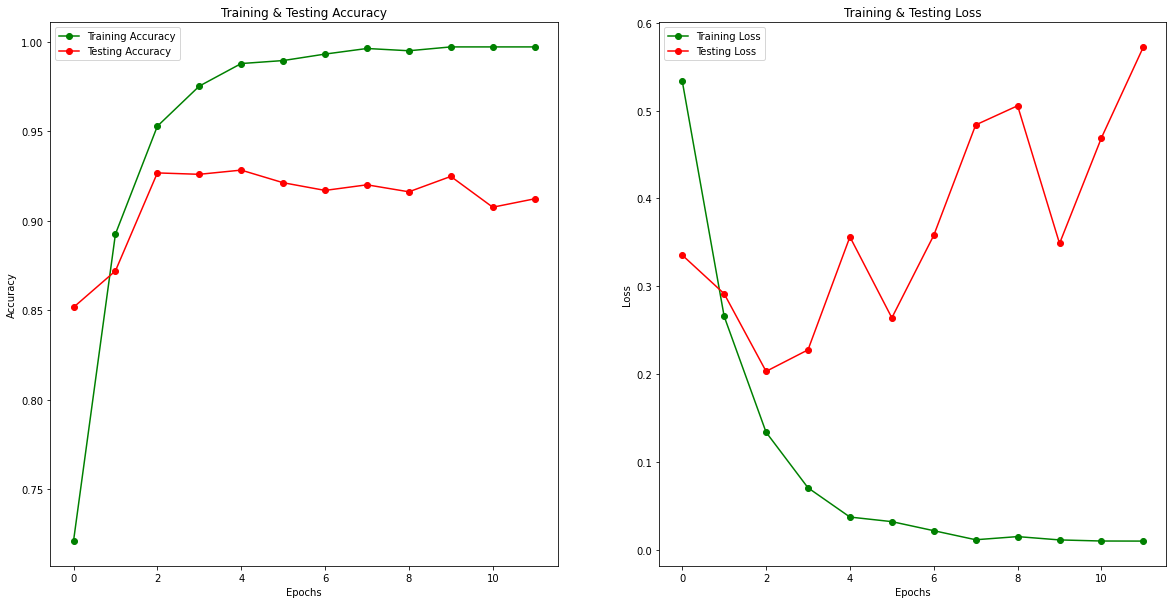

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
y_pred_softmax = model.predict(padded_test)
y_pred = []
for i in range(len(y_pred_softmax)):
  if  y_pred_softmax[i][0] >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

Accuracy: 92.84037558685446


Text(0.5, 1.0, 'Test Confusion Matrix')

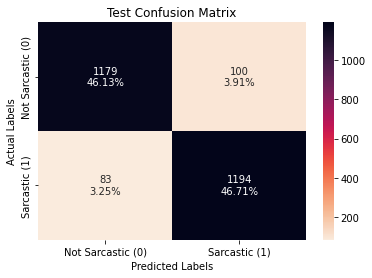

In [ ]:
print("Accuracy:", 100*accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot = labels, fmt='', cmap = sns.cm.rocket_r)
ax.xaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])
ax.yaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.set_title("Test Confusion Matrix")

In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.93      0.92      0.93      1279
    Sarcastic       0.92      0.94      0.93      1277

     accuracy                           0.93      2556
    macro avg       0.93      0.93      0.93      2556
 weighted avg       0.93      0.93      0.93      2556






# FastText - LSTM

In [ ]:
path_to_fasttext_file = os.path.join(
    os.path.expanduser("~"), "/content/drive/MyDrive/fasttext/cc.el.300.vec.gz"
)

In [ ]:
import gzip
import shutil
with gzip.open(path_to_fasttext_file, 'rb') as f_in:
    with open('file.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index_for_fasttext = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open('file.txt'))

In [ ]:
print("Found %s word vectors." % len(embeddings_index_for_fasttext))

Found 2000000 word vectors.


In [ ]:
vocab_size = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index_for_fasttext.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
        #print('hit: ', word)
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19174 words (5405 misses)


In [ ]:
tf.keras.backend.clear_session()
input = Input(shape = (max_len, ), name = "input")
embedding = Embedding(input_dim = vocab_size, 
                      output_dim = embedding_dim, # fasttext vector size
                      weights = [embedding_matrix], 
                      trainable = True)(input)

dropout = SpatialDropout1D(.25)(embedding)

lstm = LSTM(180, return_sequences=True)(dropout)
normalization = Dropout(.5)(lstm)

lstm2 = LSTM(90)(normalization)
normalization2 = Dropout(.2)(lstm2)

lstm3 = LSTM(40)(normalization)
normalization3 = Dropout(.5)(lstm3)

dense = Dense(20, activation = "relu")(normalization3)

output = Dense(1, activation = "sigmoid")(dense)

model = Model(inputs = input, outputs = output)

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 26)]              0         
                                                                 
 embedding (Embedding)       (None, 26, 300)           7374300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 26, 300)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 26, 180)           346320    
                                                                 
 dropout (Dropout)           (None, 26, 180)           0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                35360     
                                                             

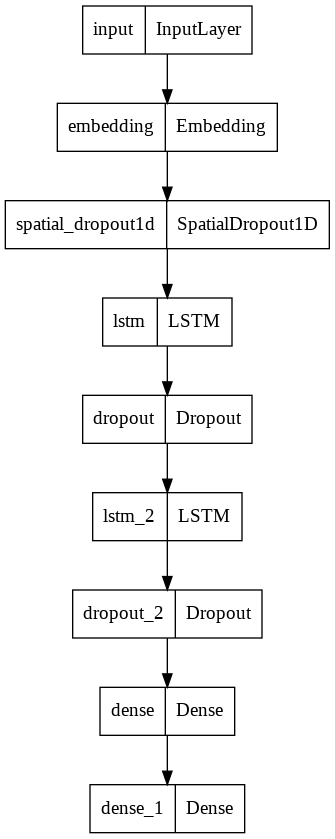

In [ ]:
plot_model(model, to_file='model_fasttext_plot.png', show_layer_names=True)

In [ ]:
history = model.fit(padded_train, y_train, batch_size = batch_size , validation_data = (padded_test,y_test) , epochs = 100, callbacks=[es])

NameError: ignored

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(padded_test,y_test)[1]*100)

80/80 [==============================] - 3s 40ms/step - loss: 0.1979 - accuracy: 0.9237
Accuracy of the model on Testing Data is -  92.37089157104492


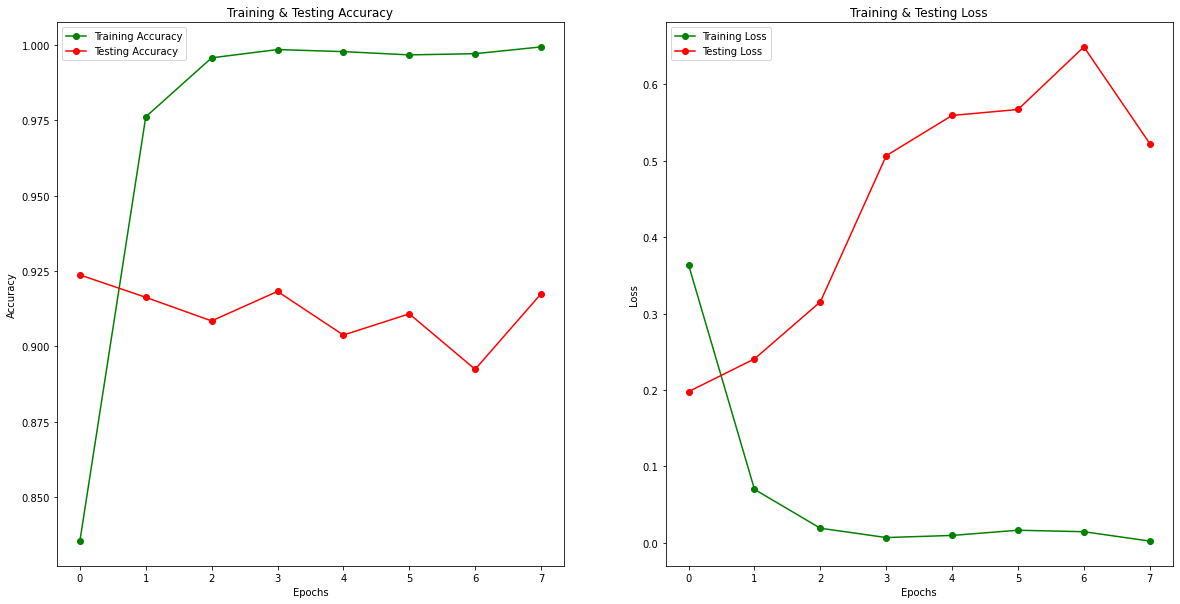

In [ ]:
epochs = [i for i in range(8)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
y_pred_softmax = model.predict(padded_test)
y_pred = []
for i in range(len(y_pred_softmax)):
  if  y_pred_softmax[i][0] >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

Accuracy: 92.37089201877934


Text(0.5, 1.0, 'Test Confusion Matrix')

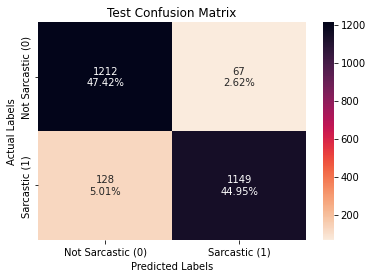

In [ ]:
print("Accuracy:", 100*accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot = labels, fmt='', cmap = sns.cm.rocket_r)
ax.xaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])
ax.yaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.set_title("Test Confusion Matrix")

In [ ]:
print(classification_report(y_test, y_pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.90      0.95      0.93      1279
    Sarcastic       0.94      0.90      0.92      1277

     accuracy                           0.92      2556
    macro avg       0.92      0.92      0.92      2556
 weighted avg       0.92      0.92      0.92      2556



# Bert

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.4 MB/s 
     |████████████████████████████████| 120 kB 25.2 MB/s 
     |████████████████████████████████| 6.6 MB 38.3 MB/s 


In [ ]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from tensorflow.keras import layers


In [ ]:
bert_pretrained = 'nlpaueb/bert-base-greek-uncased-v1'

bert_tokenizer = BertTokenizer.from_pretrained(bert_pretrained, do_lower_case=True, add_special_tokens=True,
                                                max_length=max_len+2, pad_to_max_length=True)
#bert_model = TFBertForSequenceClassification.from_pretrained(bert_pretrained, num_labels = unique_classes.size, output_hidden_states=True)

In [ ]:
import unicodedata

def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in tqdm(sentences):
        sentence = ''.join(c for c in unicodedata.normalize('NFD', sentence)
                  if unicodedata.category(c) != 'Mn').lower()
        # print(sentence)
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=max_len+2, pad_to_max_length=True, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])  
        # print(inputs)      
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


In [ ]:
sentences = df.headline
labels = df.is_sarcastic

In [ ]:
input_ids, attention_masks, input_segments = tokenize(sentences, bert_tokenizer)

  0%|          | 0/12710 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 12710/12710 [00:09<00:00, 1358.99it/s]


In [ ]:
len(input_ids),len(attention_masks),len(input_segments),len(labels)

print('Input shape {}\nAttention mask shape {}\nInput segment shape {}\nInput label shape {}'.format(input_ids.shape,attention_masks.shape,input_segments.shape,labels.shape))


Input shape (12710, 28)
Attention mask shape (12710, 28)
Input segment shape (12710, 28)
Input label shape (12710,)


In [ ]:
train_inp, val_inp, train_label, val_label, train_mask, val_mask, train_seg, val_seg=train_test_split(input_ids, labels, attention_masks, input_segments, test_size=0.2)
print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}\nTrain segment shape {} Val segment shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape, train_seg.shape, val_seg.shape))

Train inp shape (10168, 28) Val input shape (2542, 28)
Train label shape (10168,) Val label shape (2542,)
Train attention mask shape (10168, 28) Val attention mask shape (2542, 28)
Train segment shape (10168, 28) Val segment shape (2542, 28)


In [ ]:
config = BertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False

In [ ]:
transformer_model = TFBertModel.from_pretrained('nlpaueb/bert-base-greek-uncased-v1')

input_ids_in = tf.keras.layers.Input(shape=(max_len+2,), name='input_ids_in', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_len+2,), name='input_masks_in', dtype='int32') 
segment_ids = tf.keras.layers.Input(shape=(max_len+2,), name='segment_ids', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in, token_type_ids = segment_ids)[0]



X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))(embedding_layer)


X = tf.keras.layers.Dropout(0.5)(X)
X = tf.keras.layers.Dense(1, activation='sigmoid')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in, segment_ids], outputs = X)

for layer in model.layers[:3]:
  layer.trainable = False

Some layers from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_in (InputLayer)      [(None, 28)]         0           []                               
                                                                                                  
 input_masks_in (InputLayer)    [(None, 28)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 28)]         0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  112921344   ['input_ids_in[0][0]',           
                                thPoolingAndCrossAt               'input_masks_in[0][0]',   

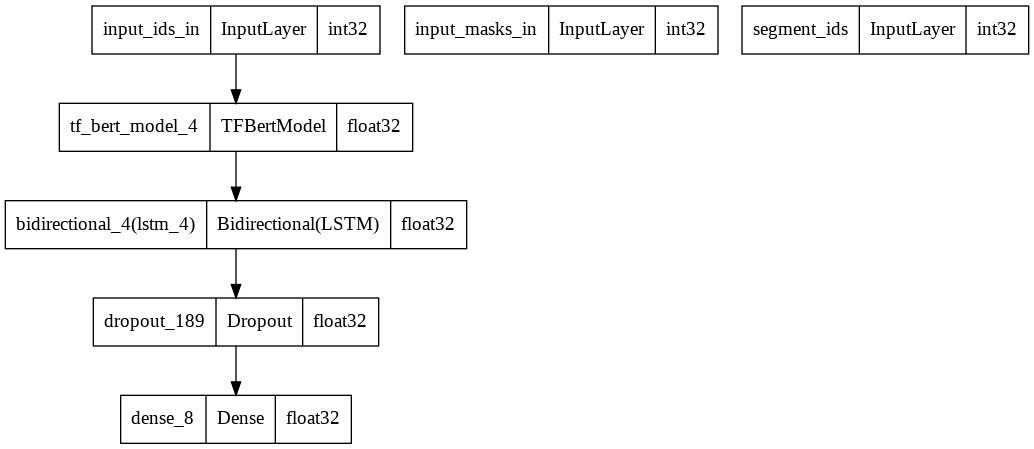

In [ ]:
plot_model(model, to_file='model_bert_plot.png', show_layer_names=True,  show_dtype=True)

In [ ]:
history=model.fit([train_inp, train_mask],train_label,batch_size=32,epochs=8,validation_data=([val_inp, val_mask],val_label), callbacks=[es])

Epoch 1/8


TypeError: ignored

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate([val_inp, val_mask, val_seg],val_label)[1]*100)

79/79 [==============================] - 263s 3s/step - loss: 0.1731 - accuracy: 0.9359
Accuracy of the model on Testing Data is -  93.58820915222168


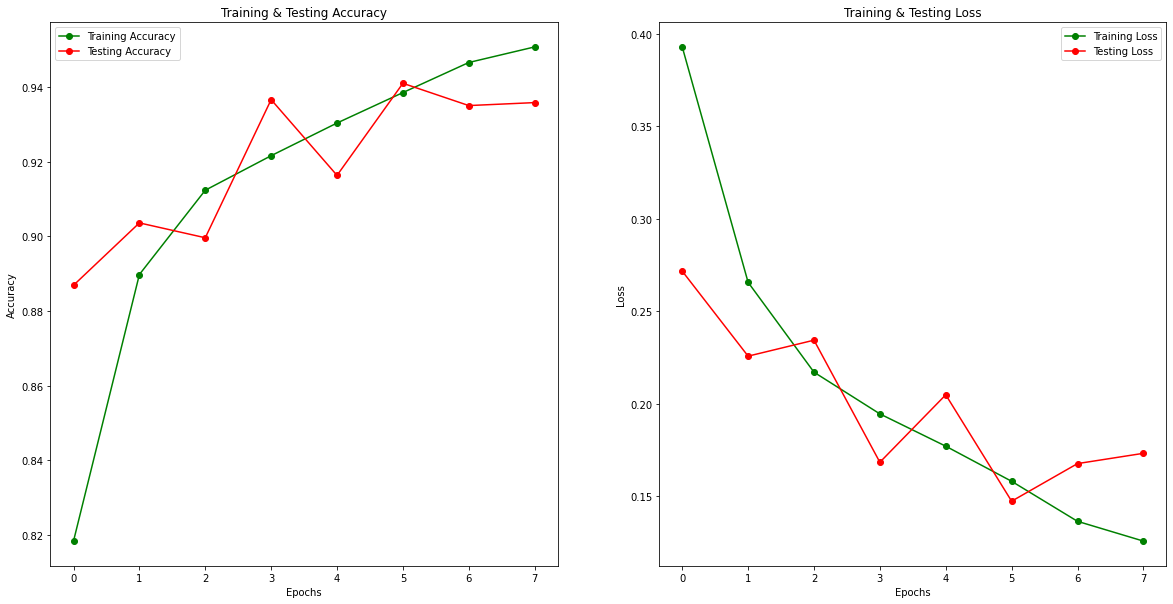

In [ ]:
epochs = [i for i in range(8)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
test_pred = model.predict([val_inp, val_mask])
prediction = np.where(test_pred>.5, 1,0)

Accuracy: 93.58821186778175


Text(0.5, 1.0, 'Test Confusion Matrix')

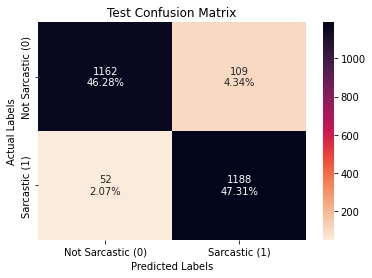

In [ ]:
print("Accuracy:", 100*accuracy_score(val_label, prediction))
cm = confusion_matrix(val_label, prediction)

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot = labels, fmt='', cmap = sns.cm.rocket_r)
ax.xaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])
ax.yaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.set_title("Test Confusion Matrix")

In [ ]:
print(classification_report(val_label,prediction,target_names= ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.96      0.91      0.94      1271
    Sarcastic       0.92      0.96      0.94      1240

     accuracy                           0.94      2511
    macro avg       0.94      0.94      0.94      2511
 weighted avg       0.94      0.94      0.94      2511



# Remove stopwords & punctuation from dataframe

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('greek')
stop = stop + ['είναι','τη', 'της', 'τις', 'από', 'μια', 'τους', 'στις', 'ότι', 'σαν', 'σήμερα', 'RT', 'number', 'χρονος', 'στα', 'χρόνια', 'πριν', 'numberχρονος', 'numberχρονη', 'μας', 'έχει', 'σας', 'μου','είναι', 'ένα']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
import string
rem = string.punctuation

punct = "?!.,#\'()*+-:;<=>@[\\]^_`{|}~`«»" + '""“”’' + '∞÷•−∅³‘₹´°\×™√²—–&'

rem = rem + punct
pattern = r"[{}]".format(rem)

In [ ]:
df['headline'] = df['headline'].str.replace(pattern, '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
df['headline'] = df['headline'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [ ]:
import matplotlib as mpl
from matplotlib.cm import ScalarMappable

In [ ]:
from collections import Counter
p = Counter("".join(df.headline).split()).most_common(15)
p1 = Counter(" ".join(df.headline).split()).most_common(15)
rslt = pd.DataFrame(p+p1, columns=['Word', 'Frequency'])
print(rslt)

         Word  Frequency
0       στους        263
1         νέα        255
2      ελλάδα        189
3     έλληνες        189
4         δύο        180
5        λόγω        180
6         πιο        164
7     σύμφωνα        164
8       έχουν        142
9       κάνει        132
10      χωρίς        126
11      πλέον        125
12        πώς        119
13       είχε        114
14        νέο        110
15     αρχείο        330
16        νέα        327
17      στους        276
18     ελλάδα        250
19      χώρας        227
20    έλληνες        214
21        δύο        208
22    numberη        207
23     έρευνα        204
24  κυβέρνηση        202
25        πιο        189
26        ηπα        183
27       λόγω        181
28        πώς        175
29   ουκρανία        172


# WordCloud

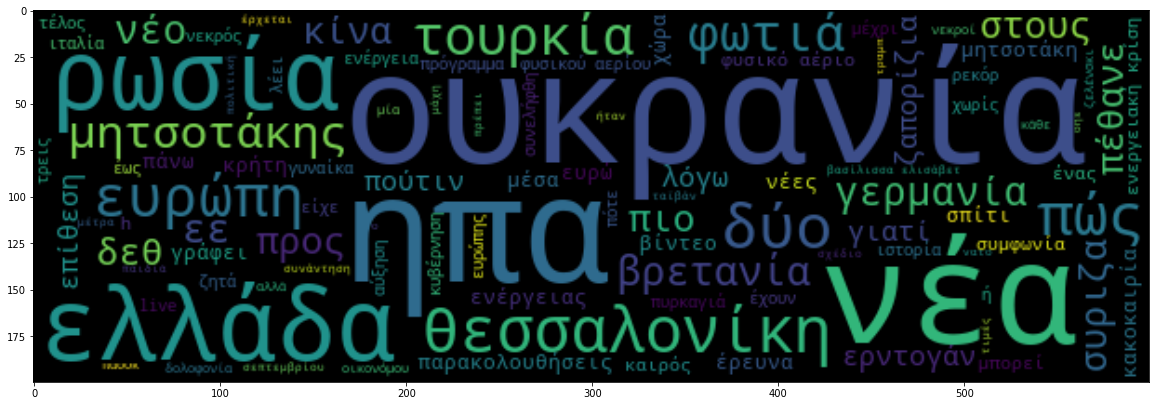

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 100 , width = 600 , height = 200).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

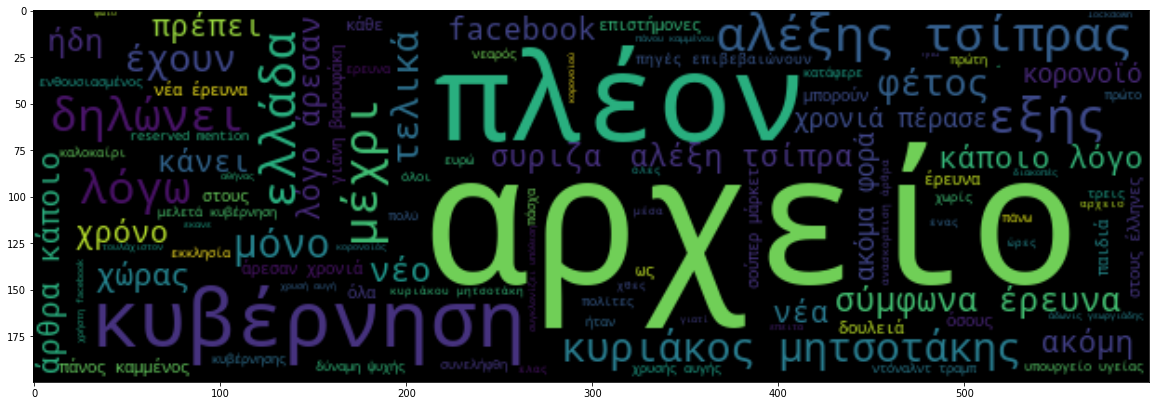

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 100 , width = 600 , height = 200).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( df.headline, df.is_sarcastic , test_size = 0.2) 

# TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=2, stop_words=stop, ngram_range=(1,1))
features_train = vectorizer.fit_transform(X_train)
features_test = vectorizer.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['rt', 'δι', 'ἀλλ'] not in stop_words.
  % sorted(inconsistent)


## Naive Bayes

In [ ]:
naive_bayes_classifier_tfidf = MultinomialNB()
naive_bayes_classifier_tfidf.fit(features_train, Y_train)

MultinomialNB()

In [ ]:
from sklearn import metrics
y_pred = naive_bayes_classifier_tfidf.predict(features_test)

Accuracy: 90.75167256985439


Text(0.5, 1.0, 'Test Confusion Matrix')

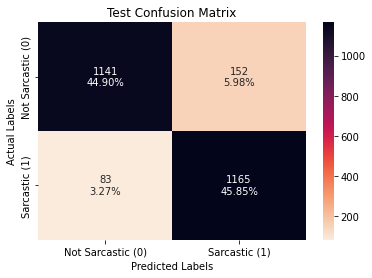

In [ ]:
print("Accuracy:", 100*accuracy_score(Y_test, y_pred))
cm = confusion_matrix(Y_test, y_pred)
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot = labels, fmt='', cmap = sns.cm.rocket_r)
ax.xaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])
ax.yaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.set_title("Test Confusion Matrix")

In [ ]:
print(metrics.classification_report(Y_test, y_pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.93      0.88      0.91      1293
    Sarcastic       0.88      0.93      0.91      1248

     accuracy                           0.91      2541
    macro avg       0.91      0.91      0.91      2541
 weighted avg       0.91      0.91      0.91      2541



## Logistic Regression

In [ ]:
scikit_log_reg = LogisticRegression()
scikit_log_reg=scikit_log_reg.fit(features_train,Y_train)

In [ ]:
y_pred = scikit_log_reg.predict(features_test)

Accuracy: 90.71231798504526


Text(0.5, 1.0, 'Test Confusion Matrix')

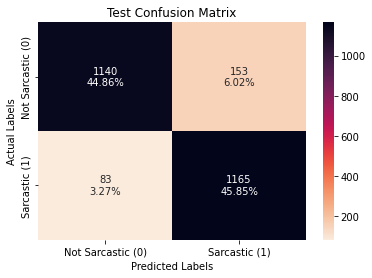

In [ ]:
print("Accuracy:", 100*accuracy_score(Y_test, y_pred))
cm = confusion_matrix(Y_test, y_pred)
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot = labels, fmt='', cmap = sns.cm.rocket_r)
ax.xaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])
ax.yaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.set_title("Test Confusion Matrix")

In [ ]:
print(metrics.classification_report(Y_test, y_pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.93      0.88      0.91      1293
    Sarcastic       0.88      0.93      0.91      1248

     accuracy                           0.91      2541
    macro avg       0.91      0.91      0.91      2541
 weighted avg       0.91      0.91      0.91      2541



## SVM

In [ ]:
SVM = svm.SVC()
SVM.fit(features_train,Y_train)

SVC()

In [ ]:
y_pred = SVM.predict(features_test)

Accuracy: 92.24714679260134


Text(0.5, 1.0, 'Test Confusion Matrix')

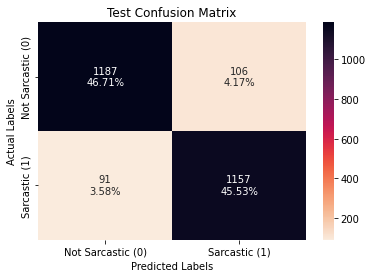

In [ ]:
print("Accuracy:", 100*accuracy_score(Y_test, y_pred))
cm = confusion_matrix(Y_test, y_pred)
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot = labels, fmt='', cmap = sns.cm.rocket_r)
ax.xaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])
ax.yaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.set_title("Test Confusion Matrix")

In [ ]:
print(metrics.classification_report(Y_test, y_pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.93      0.92      0.92      1293
    Sarcastic       0.92      0.93      0.92      1248

     accuracy                           0.92      2541
    macro avg       0.92      0.92      0.92      2541
 weighted avg       0.92      0.92      0.92      2541



# BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.5, min_df=2, stop_words=stop, ngram_range=(1,1))

#Fitting and transforming input data
bow_train = count_vect.fit_transform(X_train)
bow_test = count_vect.transform(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['rt', 'δι', 'ἀλλ'] not in stop_words.
  % sorted(inconsistent)


## Naive Bayes

In [ ]:
naive_bayes_classifier_bow = MultinomialNB()
naive_bayes_classifier_bow.fit(bow_train, Y_train)

##perform classification and prediction on samples in tf_test
y_pred = naive_bayes_classifier_bow.predict(bow_test)

Accuracy: 90.31877213695395


Text(0.5, 1.0, 'Test Confusion Matrix')

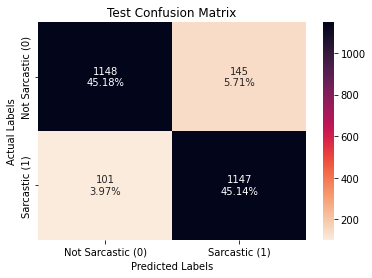

In [ ]:
print("Accuracy:", 100*accuracy_score(Y_test, y_pred))
cm = confusion_matrix(Y_test, y_pred)
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot = labels, fmt='', cmap = sns.cm.rocket_r)
ax.xaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])
ax.yaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.set_title("Test Confusion Matrix")

In [ ]:
print(classification_report(Y_test, y_pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.92      0.89      0.90      1293
    Sarcastic       0.89      0.92      0.90      1248

     accuracy                           0.90      2541
    macro avg       0.90      0.90      0.90      2541
 weighted avg       0.90      0.90      0.90      2541



## Logistic Regression

In [ ]:
scikit_log_reg_bow = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
scikit_log_reg_bow = scikit_log_reg_bow.fit(bow_train,Y_train)

[LibLinear]

In [ ]:
y_pred = scikit_log_reg_bow.predict(bow_test)

Accuracy: 91.61747343565526


Text(0.5, 1.0, 'Test Confusion Matrix')

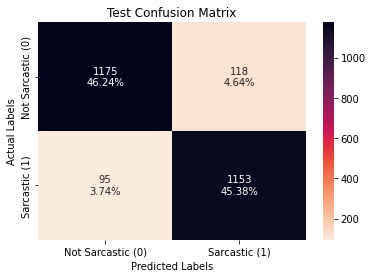

In [ ]:
print("Accuracy:", 100*accuracy_score(Y_test, y_pred))
cm = confusion_matrix(Y_test, y_pred)
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot = labels, fmt='', cmap = sns.cm.rocket_r)
ax.xaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])
ax.yaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.set_title("Test Confusion Matrix")

In [ ]:
print(classification_report(Y_test, y_pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.93      0.91      0.92      1293
    Sarcastic       0.91      0.92      0.92      1248

     accuracy                           0.92      2541
    macro avg       0.92      0.92      0.92      2541
 weighted avg       0.92      0.92      0.92      2541



## SVM

In [ ]:
SVM_bow = svm.SVC()
SVM_bow.fit(bow_train,Y_train)

SVC()

In [ ]:
y_pred = SVM_bow.predict(bow_test)

Accuracy: 90.12199921290829


Text(0.5, 1.0, 'Test Confusion Matrix')

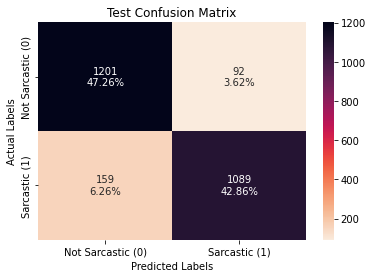

In [ ]:
print("Accuracy:", 100*accuracy_score(Y_test, y_pred))
cm = confusion_matrix(Y_test, y_pred)
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot = labels, fmt='', cmap = sns.cm.rocket_r)
ax.xaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])
ax.yaxis.set_ticklabels(['Not Sarcastic (0)', 'Sarcastic (1)'])

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("Actual Labels")
ax.set_title("Test Confusion Matrix")

In [ ]:
print(metrics.classification_report(Y_test, y_pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.88      0.93      0.91      1293
    Sarcastic       0.92      0.87      0.90      1248

     accuracy                           0.90      2541
    macro avg       0.90      0.90      0.90      2541
 weighted avg       0.90      0.90      0.90      2541

